In [2]:
%cd ..

/hdd/aouadt/these/projets/3d_segm


# Imports

In [3]:
from typing import Dict, Callable, List
from importlib import reload

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning import Trainer

from general.nn.observables import CalculateAndLogMetrics
import deep_morpho.observables.save_loss as save_loss
import deep_morpho.observables.plot_lui_parameters as plp
import deep_morpho.observables.plot_pred as plot_pred 
import deep_morpho.observables.convergence_steps as convergence_steps 
import deep_morpho.observables as obs
import deep_morpho.datasets.generate_forms3 as gfo3
import deep_morpho.datasets.multi_rect_dataset as mrd
import deep_morpho.models.lui as lui 
from general.nn.pytorch_lightning_module.obs_lightning_module import NetLightning
from deep_morpho.metrics import dice


def reload_modules():
    for modl in [save_loss, plp, plot_pred, convergence_steps, obs, gfo3, mrd, lui]:
        reload(modl)

# Fonctions

In [4]:
def intersection(ar1, ar2):
    return ar1 + ar2 == 2

def union(ar1, ar2):
    return ar1 + ar2 > 0

def fn_chans(ar, fn, chans='all'):
    if chans == 'all':
        chans = range(ar.shape[-1])
    return torch.tensor(fn(*[ar[..., chan] for chan in chans]))

def intersection_chans(ar, chans='all'):
    return fn_chans(ar, intersection, chans)

def union_chans(ar, chans='all'):
    return fn_chans(ar, union, chans)

# Sandbox

In [11]:
reload_modules()

dataloader = mrd.InputOutputGeneratorDataset.get_loader(
    batch_size=32, n_inputs=10000, random_gen_fn=gfo3.get_random_diskorect_channels,
    random_gen_args={
        "size": (50, 50, 2),
        "max_shape": (50, 50),
        "n_shapes": 1,
        "p_invert": 0,
        "n_holes": 0,
        "noise_proba": 0
    }, morp_operation=union_chans
)

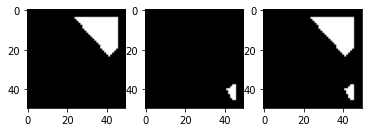

In [12]:
imgs, outs = next(iter(dataloader))
img, out = imgs[0], outs[0]

plt.subplot(131)
plt.imshow(img[..., 0], cmap='gray')

plt.subplot(132)
plt.imshow(img[..., 1], cmap='gray')

plt.subplot(133)
plt.imshow(out, cmap='gray')


In [13]:
reload_modules()
model = lui.LUI(threshold_mode="tanh", chan_inputs=2, chan_outputs=1,)

In [14]:
nn.BCELoss()(model(imgs).squeeze(), outs)

tensor(0.7056, grad_fn=<BinaryCrossEntropyBackward>)

# Training

In [5]:
reload_modules()
class LightningLUI(NetLightning):

    def __init__(
        self,
        model_args: Dict,
        learning_rate: float,
        loss: Callable,
        optimizer: Callable,
        output_dir: str,
        optimizer_args: Dict = {},
        observables: List["Observable"] = [],
    ):
        super().__init__(
            model=lui.LUI(**model_args),
            learning_rate=learning_rate,
            loss=loss,
            optimizer=optimizer,
            output_dir=output_dir,
            optimizer_args=optimizer_args,
            observables=observables,
        )
        self.save_hyperparameters()

        # new_hparams = {}
        # for key, value in self.hparams.items():
        #     if isinstance(value, dict):
        #         for key2, value2 in value.items():
        #             new_hparams[f'{key}/{key2}'] = value2
        # self.hparams.update(new_hparams)

    def obs_training_step(self, batch, batch_idx):
        x, y = batch
        predictions = self.forward(x).squeeze()

        outputs = {}

        loss_supervised = self.loss(predictions, y)
        outputs['loss'] = loss_supervised

        return outputs, predictions


In [6]:
reload_modules()

def train_lui(args):
    dataloader = mrd.InputOutputGeneratorDataset.get_loader(
        batch_size=args['batch_size'], n_inputs=args['n_inputs'], 
        random_gen_fn=gfo3.get_random_diskorect_channels,
        random_gen_args={
            "size": args["size"],
            "max_shape": args["max_shape"],
            "n_shapes": args["n_shapes"],
            "p_invert": args["p_invert"],
            "n_holes": args["n_holes"],
            "noise_proba": args["noise_proba"],
        }, morp_operation=args['morp_operation'],
        num_workers=args['num_workers']
    )
    logger = TensorBoardLogger("deep_morpho/results_lui", name="LUI_exp_1", default_hp_metric=False)
    print(f"Tb path: {logger.log_dir}")
    metrics = {'dice': lambda y_true, y_pred: dice(y_true, y_pred, threshold=.5).mean()}

    observables = [
        obs.SaveLoss(),
        CalculateAndLogMetrics(metrics=metrics, keep_preds_for_epoch=False),
        obs.PlotPreds(freq=args['freq_imgs']),
        obs.ConvergenceMetrics(metrics),
        obs.PlotLUIParameters(),
    ]

    model = LightningLUI(
        model_args={
            "threshold_mode": args['threshold_mode'],
            "chan_inputs": args['size'][-1],
            "chan_outputs": 1,
        },
        loss=args['loss'],
        optimizer=args['optimizer'],
        learning_rate=args['lr'],
        output_dir=logger.log_dir,
        observables=observables.copy()
    )

    trainer = Trainer(
        max_epochs=1,
        gpus=1,
        logger=logger,
        callbacks=observables.copy(),
        log_every_n_steps=10,
    )
    trainer.fit(model, dataloader) 
    return dataloader, model

In [8]:
reload_modules()

args = {
    "loss": nn.BCELoss(),
    "optimizer": optim.Adam,
    "lr": 1e-3,
    "freq_imgs": 100,
    "size": (50, 50, 2),
    "max_shape": (50, 50),
    "n_shapes": 1,
    "p_invert": 0,
    "n_holes": 0,
    "noise_proba": 0,
    "batch_size": 256,
    "n_inputs": 1_000_000,
    "num_workers": 20,
    "morp_operation": union_chans,
    "threshold_mode": "tanh",
}

dataloader, model = train_lui(args)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
/hdd/python_venvs/torchenv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: attribute 'observables' removed from hparams because it cannot be pickled
  warnings.warn(*args, **kwargs)
/hdd/python_venvs/torchenv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: you defined a validation_step but have no val_dataloader. Skipping val loop
  warnings.warn(*args, **kwargs)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type    | Params
----------------------------------
0 | model | LUI     | 4     
1 | loss  | BCELoss | 0     
----------------------------------
4         Trainable params
0         Non-trainable params
4         Total params
0.000     Total estimated model params size (MB)


Tb path: deep_morpho/results_lui/LUI_exp_1/version_1


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

In [1]:
imgs, outs = next(iter(dataloader))
preds = model(imgs)

img, pred, out = imgs[0], preds[0], outs[0]

plt.subplot(121)
plt.imshow(pred.detach(), vmin=0, vmax=1)

plt.subplot(122)
plt.imshow(out.detach())

NameError: name 'dataloader' is not defined